<a href="https://colab.research.google.com/github/truong-xuan-linh/CS114.L21/blob/main/BT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recognizing hand-written digits**




Firtly, we need to import some library useful

In [ ]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import sklearn

The digits dataset consists of 8x8 pixel images of digits and we have 10 class from 0 to 9:
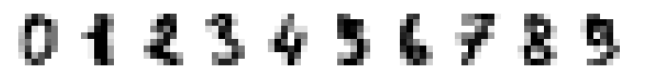

To apply a classifier on this data, we need to flatten the images, turning each 2-D array of grayscale values from shape (8, 8) into shape (64,). And we split the dataset into 80:20, 80% for train anh 20% for test

In [ ]:
#Dùng đặc trưng ma trận
digits = datasets.load_digits()
n = len(digits.images)
data = digits.images.reshape((n,-1))
x_tr, x_ts, y_tr, y_ts = train_test_split(data, digits.target, test_size = 0.2, shuffle = True)

Then, We have tried many algorithms for classification, and here is the stability of each algorithm we used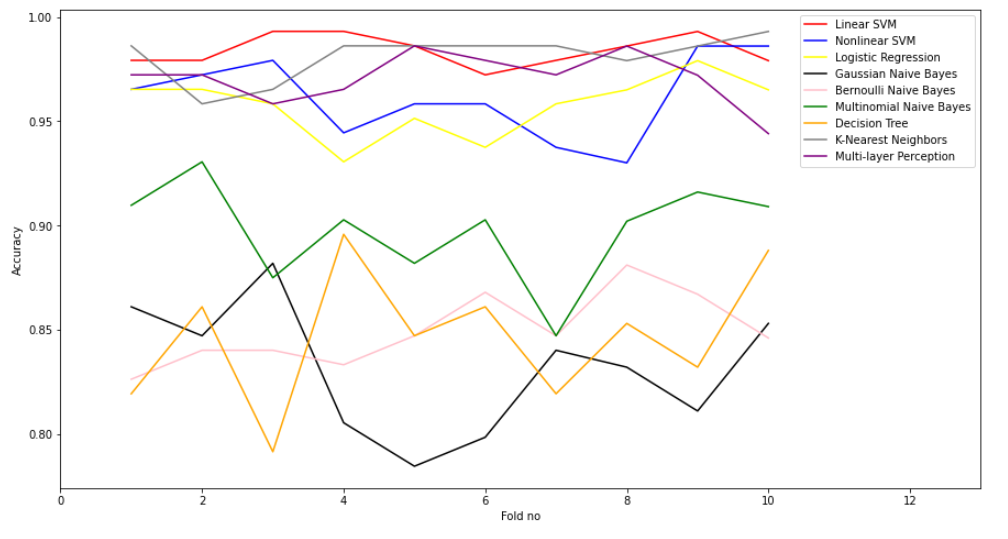
And we decided to use LinearSVM to classsifier, so we have the accuracy around 0,97 - 0,99 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.93      1.00      0.96        39
           2       0.98      1.00      0.99        42
           3       1.00      0.91      0.96        35
           4       1.00      0.95      0.97        39
           5       0.97      0.94      0.95        33
           6       0.97      1.00      0.99        35
           7       0.93      0.96      0.95        28
           8       0.97      0.93      0.95        40
           9       0.94      1.00      0.97        33

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



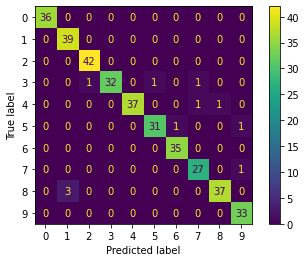

In [ ]:
#LinearSVM
classifier = svm.SVC()
classifier.fit(x_tr,y_tr)
predicted  = classifier.predict(x_ts)
print(metrics.classification_report(y_ts, predicted))
metrics.plot_confusion_matrix(classifier, x_ts, y_ts)

Use webcam from laptop to take a photo to predict

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.png', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.png


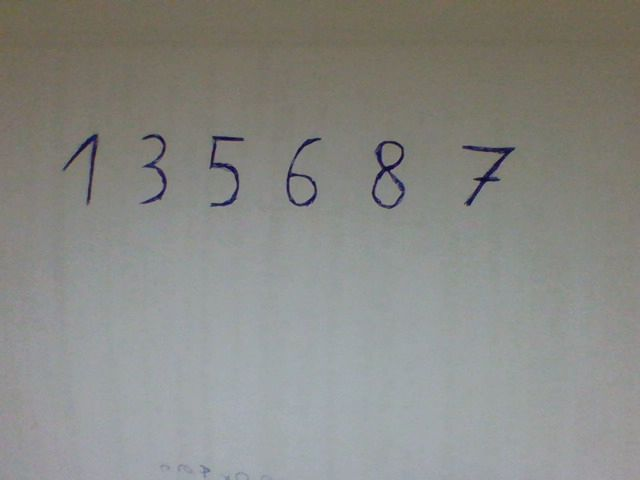

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

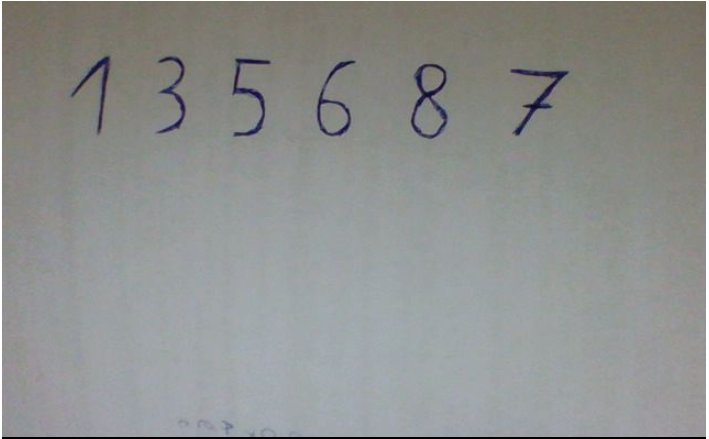

After we have an image containing the number, we need to crop the part containing the number and don't care about the rest to predict.


1.   Firtly, we convert the image to gray, increase detail, increasing contrast and blur. The purpose of this is make the image has the same format as data from scikit-learn and pay attention to the number in the image, don't care something else
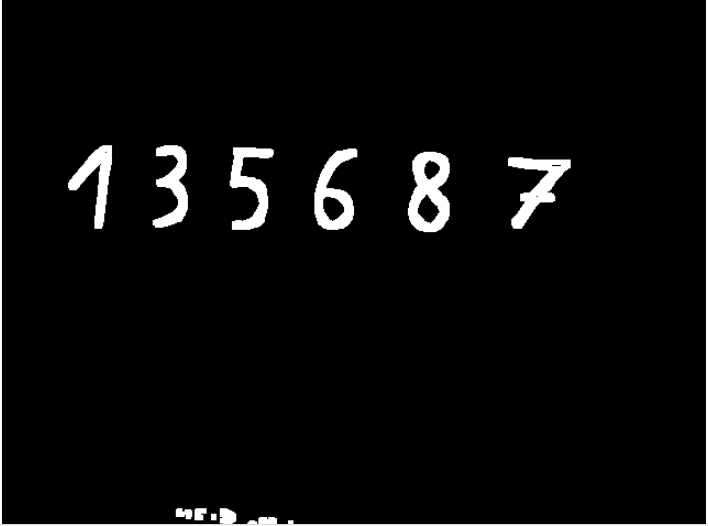
2.   Then, we crop each number in the image to predict and draw the bounding box.

    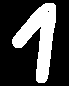  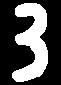  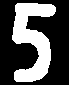  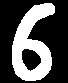  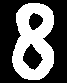  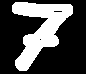




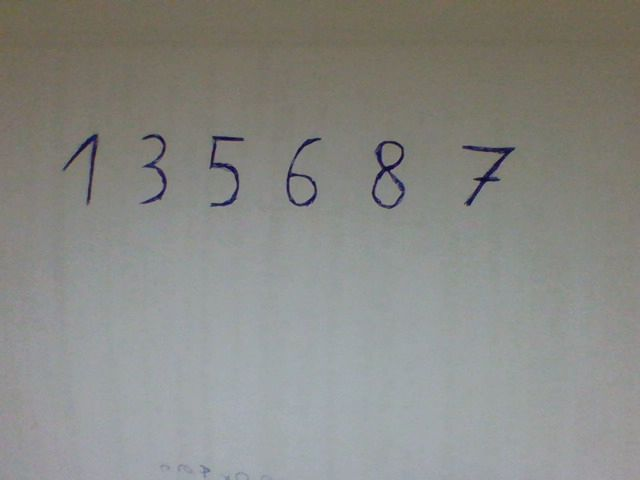

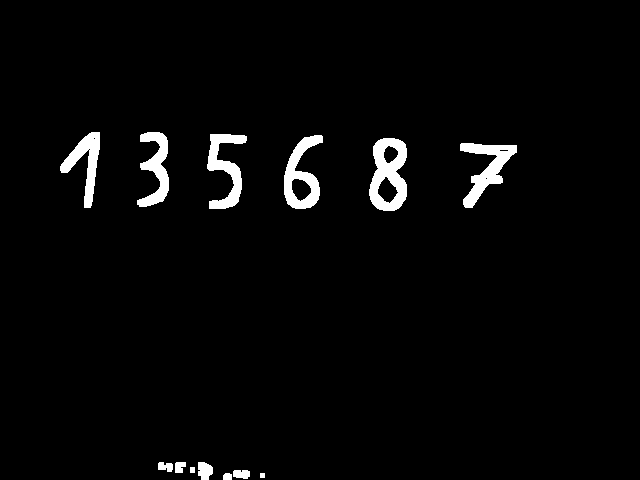

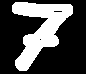

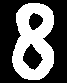

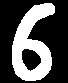

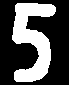

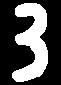

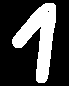

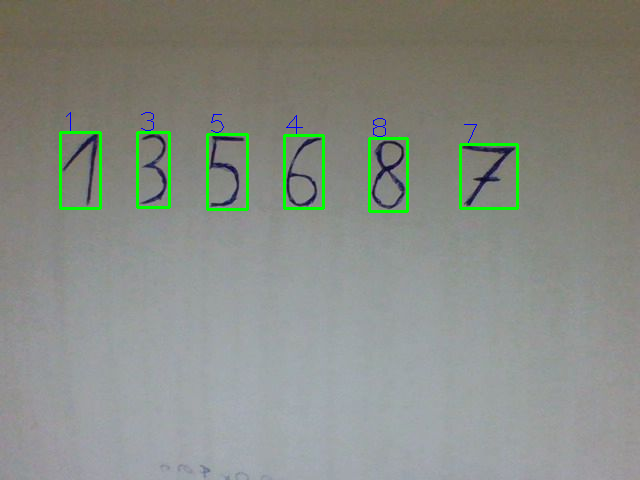

-1

In [ ]:

imgtest = cv2.imread('photo.png') #Xử lý 
img = cv2.cvtColor(imgtest, cv2.COLOR_BGR2GRAY) #Ghi đè
cv2_imshow(imgtest)
#Làm mờ, tăng chi tiết
img = cv2.GaussianBlur(img,(7,7),1)
img = cv2.Canny(img,50,50)
kernel = np.ones((5,5),np.uint8)
img = cv2.dilate(img,kernel,iterations =1)
#img = cv2.GaussianBlur(img,(7,7),1)
cv2_imshow(img)
#datatest lưu các số trong ảnh đưa vào
datatest = list()
contours, hierachy = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for cnt in contours:
  area = cv2.contourArea(cnt)
  #Khử nhiễu
  if area > 1000: 
    #Tìm các góc để vẽ hình bao quanh
    cv2.drawContours(img, cnt, -1, (255,0,0), 3)
    peri = cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt, 0.02*peri,True)
    x,y,w,h = cv2.boundingRect(approx)
    #Vẽ hình bao quanh
    cv2.rectangle(imgtest,(x,y),(x+w,y+h),(0,255,0),2)
    #Cắt số tìm được từ ảnh đưa vào
    imgCropped = img[y-5:y+h+5, x-14:x+w+15]
    #imgCroppedCanny = cv2.Canny(imgCropped,4,4)
    #Xử lý những ảnh con 1 lần nữa
    #cv2_imshow(imgCroppedCannyDialationBlur)
    # Chuyển về kích thước 8*8
    cv2_imshow(imgCropped)
    imgCropped = cv2.resize(imgCropped, (8,8))
    # Đưa về ma trận 1 chiều
    imgCropped = imgCropped.reshape(-1)/17
    #Thêm bộ dữ liệu vào datatest
    datatest.append(imgCropped)
    #Dự đoán bộ datatest
    img_predict= classifier.predict(datatest)
    #Với mỗi dự đoán, Ghi số thích hợp
    cv2.putText(imgtest,str(int(img_predict[-1])),(x,y),1,cv2.FONT_HERSHEY_DUPLEX,(255,0,0),1)    
datatest = np.array(datatest)
cv2_imshow(imgtest)
cv2.waitKey(0)